# Dynamic method comparison - Werner

In [22]:
import time
import random
import math

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


import quairkit as qkit
from quairkit import Circuit
from quairkit import to_state
from quairkit.database import *
from quairkit.loss import *
from quairkit.qinfo import *
from quairkit.database.hamiltonian import ising_hamiltonian
from quairkit.ansatz import *
from quairkit.operator import ParamOracle

qkit.set_dtype('complex128')

## Dynamic LOCCNet

In [ ]:
def dynloccnetcir(n):
    cir = Circuit(2*n)
    cir.universal_qudits(qubits_idx=[0,2,4,6])
    cir.universal_qudits(qubits_idx=[1,3,5,7])

    return cir

## 4-copy

In [ ]:
def loss_func_loccnet(cir1, m, target_state, noisy_state2):
    
    input_state1 = nkron(*[noisy_state2 for _ in range(m)])
    state1 = cir1(to_state(input_state1,eps=None))
    measure_state = Measure('z'* (2*m-2))
    _, m_state = measure_state(state1, qubits_idx=list(range(2*m-2)),keep_state=True,desired_result='0'*(2*m-2))
    output_state = partial_trace(m_state,0,[2**(2*m-2),2**2]).density_matrix

    loss = 1 - state_fidelity(target_state,output_state)**2
    f = state_fidelity(target_state,output_state).item()**2
    
    return loss, output_state,f

In [ ]:
def train_model_loccnet(num_itr, LR, m, target_state,noisy_state):
    
    loss_list, time_list = [], []
    cir1 = loccnetcir(m)
    
    opt_cir1 = torch.optim.Adam(lr=LR, params=cir1.parameters())
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir1, 'min', factor=0.5)

    print('Training:')
    
    for itr in range(num_itr):
        start_time = time.time()
        opt_cir1.zero_grad()
        loss, output_state3,_ = loss_func_loccnet(cir1, m, target_state, noisy_state) 
        loss.backward()
        opt_cir1.step()

        scheduler1.step(loss)
        loss = loss.item()
        loss_list.append(loss)
        time_list.append(time.time() - start_time)
        
        if itr % 500 == 0 or itr == num_itr - 1:
            print(
                f"iter: {itr}, loss: {loss:.8f}, lr: {scheduler1.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s"
            )
            time_list = []

    output_state = output_state3.detach()
    fid = state_fidelity(output_state,target_state).item()**2
    
    return fid

## 5-copy

In [ ]:
def loss_func_dyn_5(cir1, cir2, target_state, noisy_state2):
    
    input_state1 = torch.kron(torch.kron(torch.kron(noisy_state2,noisy_state2),noisy_state2),noisy_state2)
    state1 = cir1(to_state(input_state1,eps=None))
    measure_state = Measure('z'* 2)
    _, m_state = measure_state(state1, qubits_idx=list(range(2)),keep_state=True,desired_result='0'*2)
    output_state1 = partial_trace(m_state,0,[4,2**6]).density_matrix
        
    input_state2 = torch.kron(output_state1,noisy_state2)
    state2 = cir2(to_state(input_state2,eps=None))
    measure_state2 = Measure('z'* 6)
    _, m_state2 = measure_state2(state2, qubits_idx=list(range(6)),keep_state=True,desired_result='0'*6)
    output_state = partial_trace(m_state2,0,[2**6,4]).density_matrix
 
    loss = 1 - state_fidelity(target_state,output_state)**2
    f = state_fidelity(target_state,output_state).item()**2
    
    return loss, output_state,f

In [ ]:
def train_model_dyn_5(num_itr, LR, n, target_state,noisy_state2):
    
    loss_list, time_list = [], []
    
    cir1 = dynloccnetcir(n)
    cir2 = dynloccnetcir(n)

       
    opt_cir1 = torch.optim.Adam(lr=LR, params=cir1.parameters()) 
    opt_cir2 = torch.optim.Adam(lr=LR, params=cir2.parameters()) 
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir1, 'min', factor=0.5) 
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir2, 'min', factor=0.5) 
       
    print('Training:')
    
    for itr in range(num_itr):
        start_time = time.time()
        opt_cir1.zero_grad()
        opt_cir2.zero_grad()

        loss, output_state3,_ = loss_func_dyn_5(cir1,cir2, target_state, noisy_state2)
        loss.backward()
        opt_cir1.step()
        opt_cir2.step()
        scheduler1.step(loss) 
        scheduler2.step(loss)
 
            
        loss = loss.item()
        loss_list.append(loss)
        time_list.append(time.time() - start_time)
        
        if itr % 500 == 0 or itr == num_itr - 1:
            print(
                f"iter: {itr}, loss: {loss:.8f}, lr: {scheduler1.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s"
            )
            time_list = []

    output_state = output_state3.detach()
    fid = state_fidelity(output_state,target_state).item()**2
    
    return fid

## 6-copy

In [ ]:
def loss_func_dyn_6(cir1, cir2, cir3, target_state, noisy_state2):
    
    input_state1 = torch.kron(torch.kron(torch.kron(noisy_state2,noisy_state2),noisy_state2),noisy_state2)
    state1 = cir1(to_state(input_state1,eps=None))
    measure_state = Measure('z'* 2)
    _, m_state = measure_state(state1, qubits_idx=list(range(2)),keep_state=True,desired_result='0'*2)
    output_state1 = partial_trace(m_state,0,[4,2**6]).density_matrix
        
    input_state2 = torch.kron(output_state1,noisy_state2)
    state2 = cir2(to_state(input_state2,eps=None))
    _, m_state2 = measure_state(state2, qubits_idx=list(range(2)),keep_state=True,desired_result='0'*2)
    output_state2 = partial_trace(m_state2,0,[4,2**6]).density_matrix
    
    input_state3 = torch.kron(output_state2,noisy_state2)
    state3 = cir3(to_state(input_state3,eps=None))
    measure_state2 = Measure('z'* 6)
    _, m_state3 = measure_state2(state3, qubits_idx=list(range(6)),keep_state=True,desired_result='0'*6)
    output_state = partial_trace(m_state3,0,[2**6,4]).density_matrix

    loss = 1 - state_fidelity(target_state,output_state)**2
    f = state_fidelity(target_state,output_state).item()**2
    
    return loss, output_state,f

In [ ]:
def train_model_dyn_6(num_itr, LR, n, target_state,noisy_state):
    
    loss_list, time_list = [], []
    
    cir1 = dynloccnetcir(n)
    cir2 = dynloccnetcir(n)
    cir3 = dynloccnetcir(n)
    
    opt_cir1 = torch.optim.Adam(lr=LR, params=cir1.parameters()) 
    opt_cir2 = torch.optim.Adam(lr=LR, params=cir2.parameters()) 
    opt_cir3 = torch.optim.Adam(lr=LR, params=cir3.parameters())
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir1, 'min', factor=0.5) 
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir2, 'min', factor=0.5) 
    scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_cir3, 'min', factor=0.5) 

    
    
    print('Training:')
    
    for itr in range(num_itr):
        start_time = time.time()
        opt_cir1.zero_grad()
        opt_cir2.zero_grad()
        opt_cir3.zero_grad()

        
        loss, output_state3,_ = loss_func_dyn_6(cir1, cir2, cir3, target_state, noisy_state) 
        loss.backward()
        opt_cir1.step()
        opt_cir2.step()
        opt_cir3.step()

        scheduler1.step(loss) 
        scheduler2.step(loss)
        scheduler3.step(loss)
        
        loss = loss.item()
        loss_list.append(loss)
        time_list.append(time.time() - start_time)
        
        if itr % 500 == 0 or itr == num_itr - 1:
            print(
                f"iter: {itr}, loss: {loss:.8f}, lr: {scheduler1.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s"
            )
            time_list = []

    output_state = output_state3.detach()
    fid = state_fidelity(output_state,target_state).item()**2
    
    return fid

# Train

In [ ]:
n = 4
NUM_ITR = 2000
LR = 0.1
target_state = bell_diagonal_state([0,0,0,1]).density_matrix

fid_s = []

fid_dynamic = []
fid_loccnet = []
fid_iso1 = []



for i in range(50,105,5):
    input_f = i/100
    werner_state = input_f * target_state + (1-input_f) * (eye(4)-target_state)/3
    ## 6 copies of werner state
    f6 = train_model_dyn_6(NUM_ITR, LR, n, target_state,werner_state)
    fmins = f6-input_f
    fid_dynamic.append(fmins)

    ## 4 copies of werner state
    # f4 = train_model_loccnet(NUM_ITR, LR, 4, target_state,iso_state)
    # fmins = f4-input_f
    # fid_dynamic.append(fmins)
    
    ## 5 copies of werner state
    # fdyn5 = train_model_dyn_5(NUM_ITR, LR, n, target_state,iso_state)
    # fid_dynamic.append(fdyn5)
    # fmins = f5-input_f
    # fid_dynamic.append(fmins)    


print('multi-copy of dloccnet with 4-3',fid_dynamic)



Training:
iter: 0, loss: 0.75755855, lr: 1.00E-01, avg_time: 0.1101s
iter: 500, loss: 0.50000747, lr: 1.19E-08, avg_time: 0.0529s
iter: 1000, loss: 0.50000747, lr: 1.19E-08, avg_time: 0.0519s
iter: 1500, loss: 0.50000747, lr: 1.19E-08, avg_time: 0.0517s
iter: 1999, loss: 0.50000747, lr: 1.19E-08, avg_time: 0.0511s
Training:
iter: 0, loss: 0.75537734, lr: 1.00E-01, avg_time: 0.0489s
iter: 500, loss: 0.36929834, lr: 2.50E-02, avg_time: 0.0527s
iter: 1000, loss: 0.36574865, lr: 1.95E-04, avg_time: 0.0547s
iter: 1500, loss: 0.36574829, lr: 1.19E-08, avg_time: 0.0512s
iter: 1999, loss: 0.36574829, lr: 1.19E-08, avg_time: 0.0448s
Training:
iter: 0, loss: 0.75087339, lr: 1.00E-01, avg_time: 0.0427s
iter: 500, loss: 0.24003849, lr: 1.25E-02, avg_time: 0.0470s
iter: 1000, loss: 0.23831636, lr: 1.25E-02, avg_time: 0.0495s
iter: 1500, loss: 0.23809640, lr: 1.19E-08, avg_time: 0.0497s
iter: 1999, loss: 0.23809640, lr: 1.19E-08, avg_time: 0.0531s
Training:
iter: 0, loss: 0.73123411, lr: 1.00E-01, a

## Analysis of bilocal Clifford

In [38]:
# 4-6 copy
f_list = []
fmins_list_6 = []
fmins_list_5 = []
fmins_list_4 = []

for i in range(50,105,5):
    f = i/100
    f_list.append(f)
    f_p = (32/27)*(f**5)-(20/27)*(f**4)+(10/9)*(f**3)-(20/27)*(f**2)+(5/27)*(f)
    p = (80/27)*(f**4)-(80/27)*(f**3)+(10/9)*(f**2)-(5/27)*(f)+2/27
    f_dis = f_p/p
    fmins = f_dis-f
    fmins_list_5.append(fmins)
    
    f_p_4 = (8/9)*(f**4)+(8/27)*(f**3)-(2/9)*(f**2)+1/27
    p_4 = (32/27)*(f**4)-(4/9)*(f**2)+(4/27)*(f)+1/9
    f_dis_4 = f_p_4/p_4
    fmins_4 = f_dis_4-f
    fmins_list_4.append(fmins_4)
    
    f_p_6 = (32/27)*(f**6)-(112/243)*(f**5)+(80/243)*(f**4)+(8/243)*(f**3)-(32/243)*(f**2)+(10/243)*f+1/243
    p_6 = (128/243)*(f**6)+(320/243)*(f**5)-(256/243)*(f**4)+(16/243)*(f**3)+(40/243)*(f**2)-(14/243)*f+1/27
    f_dis_6 = f_p_6/p_6
    fmins_6 = f_dis_6-f
    fmins_list_6.append(fmins_6)
print(f_list)
print(fmins_list_6)
print(fmins_list_5)
print(fmins_list_4)
    



[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
[1.1102230246251565e-16, 0.08548878427028539, 0.16262163459440615, 0.2110176263025646, 0.22632612966601218, 0.21477663230240596, 0.18518537438857763, 0.14485499361309506, 0.09873713783534988, 0.04986814940838413, -1.1102230246251565e-16]
[2.220446049250313e-16, 0.08011560693641706, 0.15357340720221513, 0.20170793735778192, 0.21913043478260819, 0.2102803738317759, 0.18287744227353508, 0.14391937290033596, 0.09847695390781619, 0.04983800339786015, 0.0]
[0.0, 0.05294117647058827, 0.10370370370370363, 0.1423728813559323, 0.1636363636363637, 0.16666666666666674, 0.15348837209302335, 0.1272727272727271, 0.09122807017543844, 0.048091603053435183, 0.0]


## Data

In [ ]:
fdyn_5 = [-1.890476889515602e-05, 0.07969467376779826, 0.15347212583758663, 0.201643434184816, 0.2189821298639616, 0.21020705067771805, 0.18232634770068412, 0.14201283148999455,   0.0946769200923746, 0.0481275265128136, 5.999938323952847e-10]
fdyn_4 = [-5.444716921765291e-08, 0.052830484868721106, 0.10367846752245569, 0.1423465977909968, 0.1636063185216794, 0.16656890542179703, 0.15342424121965803, 0.12696695327566643, 0.09010230823734111, 0.047720758388093865, 5.99996052841334e-10]
fdyn_6 = [-3.5096562374881124e-05, 0.08390583356951187, 0.1580441628710798, 0.20400938358623177, 0.2207917040733851, 0.20751030926011937, 0.17902864890905867, 0.13798096561141848, 0.09512976174730303, 0.04802147107559507, 5.999880592355566e-10]

fmins_list_6 = [1.1102230246251565e-16, 0.08548878427028539, 0.16262163459440615, 0.2110176263025646, 0.22632612966601218, 0.21477663230240596, 0.18518537438857763, 0.14485499361309506, 0.09873713783534988, 0.04986814940838413, -1.1102230246251565e-16]
fmins_list_5 = [2.220446049250313e-16, 0.08011560693641706, 0.15357340720221513, 0.20170793735778192, 0.21913043478260819, 0.2102803738317759, 0.18287744227353508, 0.14391937290033596, 0.09847695390781619, 0.04983800339786015, 0.0]
fmins_list_4 = [0.0, 0.05294117647058827, 0.10370370370370363, 0.1423728813559323, 0.1636363636363637, 0.16666666666666674, 0.15348837209302335, 0.1272727272727271, 0.09122807017543844, 0.048091603053435183, 0.0]

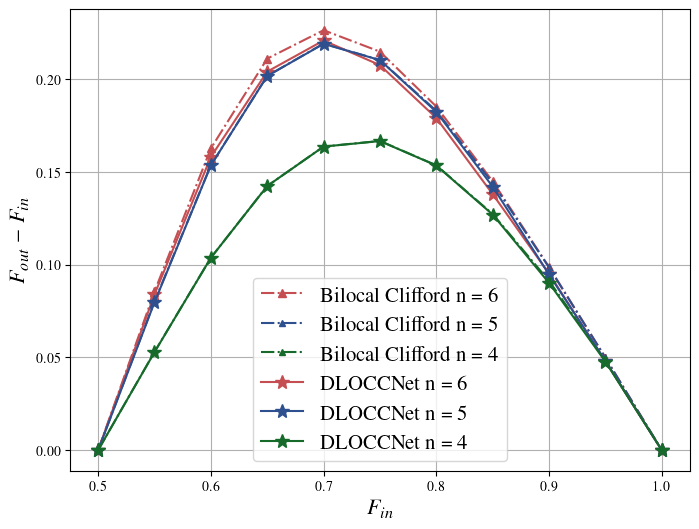

In [ ]:
plt.rcParams.update({
    "text.usetex": True,   
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{newtxtext}\usepackage{newtxmath}"
})

plt.rcParams['legend.fontsize'] = 50

plt.figure(figsize=(8,6))
plt.gca()   

plt.plot(f_list, fmins_list_6, "-.",marker='^',markersize=6, color='#C44E52', label = f"Bilocal Clifford n = 6")
plt.plot(f_list, fmins_list_5, "-.",marker='^',markersize=5, color="#5986D9", label = f"Bilocal Clifford n = 5")
plt.plot(f_list, fmins_list_4, "-.",marker='^',markersize=5, color="#299143", label = f"Bilocal Clifford n = 4")

plt.plot(f_list, fdyn_6, "-",marker='*',markersize=10, color='#C44E52', label = f"DLOCCNet n = 6")
plt.plot(f_list, fdyn_5, "-",marker='*',markersize=10, color="#5986D9", label = f"DLOCCNet n = 5")
plt.plot(f_list, fdyn_4, "-",marker='*',markersize=10, color="#299143", label = f"DLOCCNet n = 4")

plt.xlabel("$F_{in}$", fontsize=16)
plt.ylabel("$F_{out}-F_{in}$", fontsize=16)

plt.legend(prop={'size':15})
plt.grid()
plt.show()